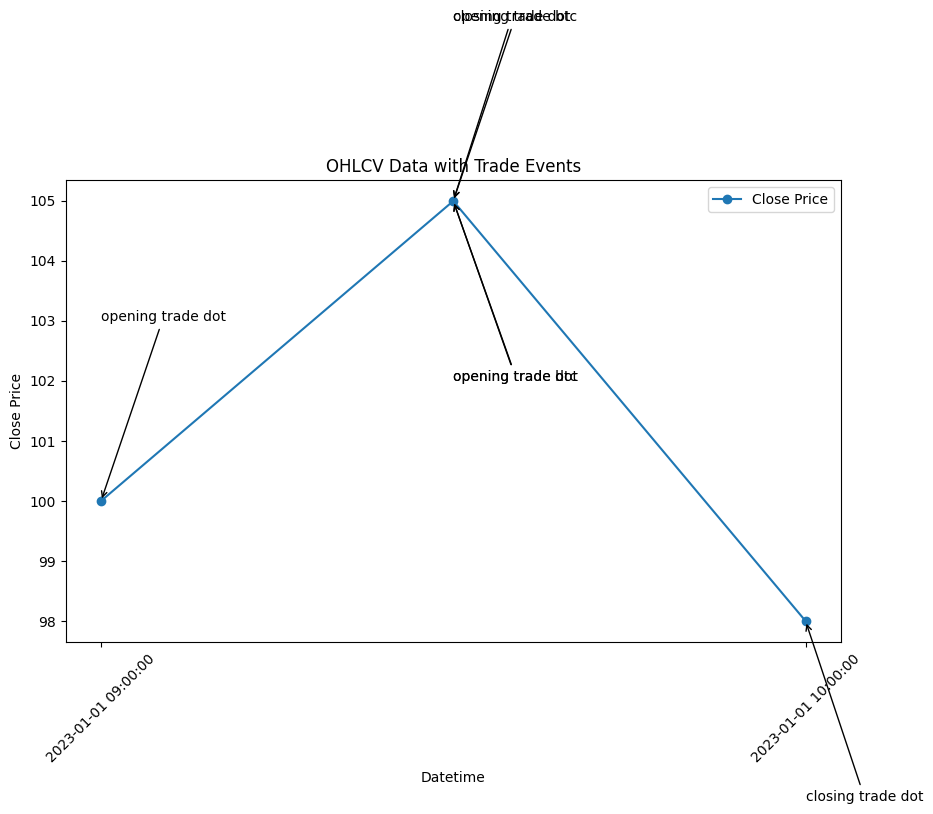

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Sample OHLCV data
datetime_list = ["2023-01-01 09:00:00", "2023-01-01 09:30:00", "2023-01-01 10:00:00"]
close_prices = [100, 105, 98]
trade_open_times = ["2023-01-01 09:15:00", "2023-01-01 09:30:00", "2023-01-01 09:45:00"]
trade_close_times = ["2023-01-01 09:30:00", "2023-01-01 09:45:00", "2023-01-01 10:15:00"]
trade_symbols = ["opening trade dot", "opening trade btc", "closing trade dot"]

# Convert strings to datetime objects
datetime_list = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in datetime_list]
trade_open_times = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in trade_open_times]
trade_close_times = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in trade_close_times]

# Plot OHLCV data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(datetime_list, close_prices, label='Close Price', marker='o', linestyle='-')

# Annotate trade events with different symbols on the line
for time, symbol in zip(trade_open_times, trade_symbols):
    closest_time = min(datetime_list, key=lambda x: abs(x - time))
    index = datetime_list.index(closest_time)
    ax.annotate(f'{symbol}', xy=(closest_time, close_prices[index]),
                xytext=(closest_time, close_prices[index] + 3),
                arrowprops=dict(facecolor='g', arrowstyle='->'))

for time, symbol in zip(trade_close_times, trade_symbols):
    closest_time = min(datetime_list, key=lambda x: abs(x - time))
    index = datetime_list.index(closest_time)
    ax.annotate(f'{symbol}', xy=(closest_time, close_prices[index]),
                xytext=(closest_time, close_prices[index] - 3),
                arrowprops=dict(facecolor='r', arrowstyle='->'))

# Format x-axis as datetime
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

# Display legend
ax.legend()

# Show the plot
plt.title('OHLCV Data with Trade Events')
plt.xlabel('Datetime')
plt.ylabel('Close Price')
plt.show()
